# STAT5243 Project 3: Imbalanced image classification

#### Group 2:

## Step 0: Set up

In [1]:
RUN_TEST = False # run evaluation on an independent test set

In [3]:
%run "Documents/R/Spring2021-Project3-group-2/lib/functions.py"
%run "Documents/R/Spring2021-Project3-group-2/lib/feature.py"
if RUN_TEST:
    %run "Documents/R/Spring2021-Project3-group-2/lib/test.py"
else:
    %run "Documents/R/Spring2021-Project3-group-2/lib/train.py"

Install libraries as needed: [tensorflow](https://www.tensorflow.org/install)

In [4]:
#import tensorflow and check version
import tensorflow as tf
print(tf.__version__)

2.4.1


Note: Google colab has tensorflow installed, but if you use Anaconda jupyter book,
you need to copy and paste the following command into the anaconda prompt
`conda install -c conda-forge tensorflow` or install tensorflow inside the jupyter notebook by the line 
`!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org --upgrade tensorflow`

Import other libraries and set up parameters as needed.

In [5]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import random
import sys
import time
import scipy.io as sio
import warnings
warnings.filterwarnings('ignore')
#import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import sklearn.metrics
import sklearn.preprocessing
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, plot_roc_curve, auc
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV, LeaveOneOut, KFold
from sklearn.pipeline import make_pipeline

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 100
IMG_SIZE_MN = 160
IMG_SIZE = 192
SHUFFLE_SIZE = 1000
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

Set a random seed for reproduction.

In [6]:
RANDOM_STATE = np.random.seed(2020)

Set up controls for the evaluation experiments.

In [7]:
READ_PTS = False # read fiducial points from directory
RUN_CV = True # run cross-validation on the training set
SAMPLE_REWEIGHT = True # run sample reweighting in model training
K = 5  # number of CV folds
FIT_MODEL = True
RUN_FEATURES_TRAIN = False # process features for training set
RUN_FEATURES_TEST = False # process features for test set

Next, we need to change the working directory to where the datasets are located.

In [8]:
if RUN_TEST:
    os.chdir('Downloads/test_set_predict/')
    #|--test_set_predict
    #   |--points
    #      |--XXXX.mat
    #   |--images
    #      |--XXXX.jpg
    #   |--label_prediction.csv
else:
    os.chdir('Downloads/train_set/')

Set file directories for images, fiducial points and feature sets.

In [10]:
filenames = glob.glob("images/*.jpg")
pt_filenames = glob.glob("points/*.mat")
#path_imgs = f"data//train_set//images//{index:04d}.jpg"
#path_points = f"data//train_set//points//{index:04d}.mat"
filenames.sort()
pt_filenames.sort()

output_dir = 'C:/Users/Chloe/Documents/R/Spring2021-Project3-group-2/output/'

## Step 1: Load images, fiducial points, and feature sets

In [11]:
# load images in order
# Reference： https://appdividend.com/2020/09/19/python-cv2-understand-image-types-and-color-channels/
images = [cv2.imread(img) for img in filenames]

# overview of the dataset
print("Number of images: ", len(images))
print("Size of each image: ",images[0].shape)

Number of images:  3000
Size of each image:  (750, 1000, 3)


Note: the dataset is imbalanced

In [12]:
# read fiducial points from .mat files
# function load_points(path) in the script functions.py
points_list = [load_points(path) for path in pt_filenames]
data_points = np.asarray(points_list, dtype=np.float32)
print(data_points.shape)

(3000, 78, 2)


0    2402
1     598
Name: label, dtype: int64
Image shape:  (750, 1000, 3)
Class: 0


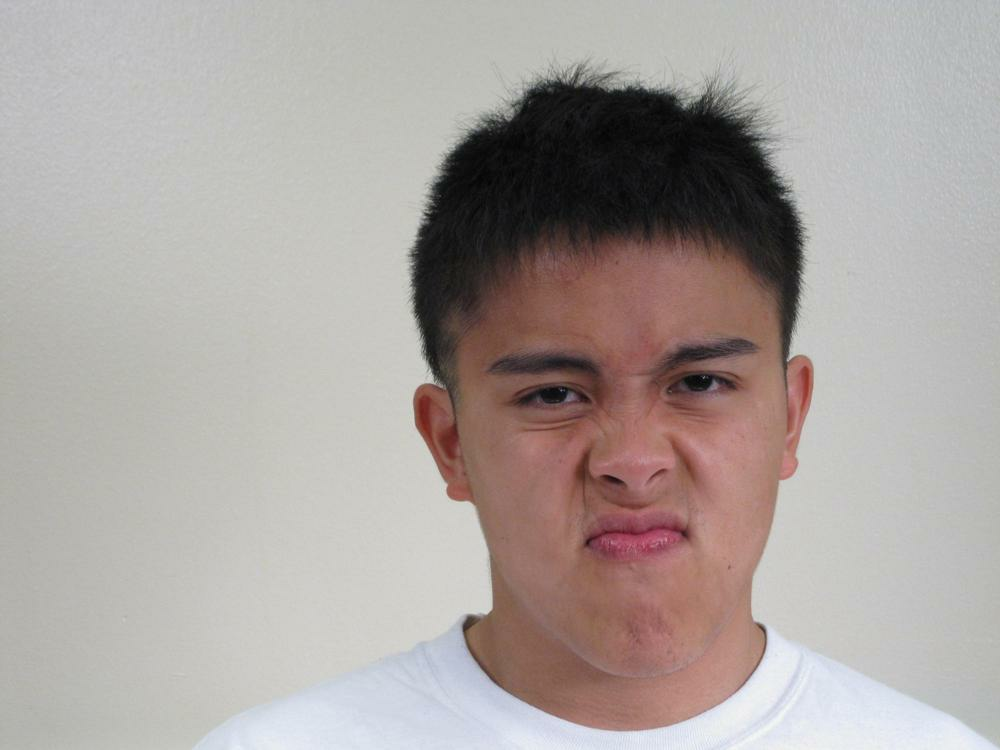

In [13]:
# load labels
labels = pd.read_csv("label.csv")
print(labels['label'].value_counts())
n_zeros = labels['label'].value_counts()[0]
n_ones = labels['label'].value_counts()[1]

# Sample original image
label = labels['label'][1]
img_orig = tf.image.decode_jpeg(tf.io.read_file(filenames[1]), channels=3)
show(img_orig, label)

Image shape:  (192, 192, 3)
Class: 0


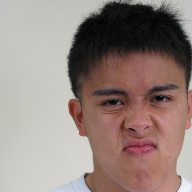

In [14]:
# Sample processed image
# Functions preprocess_image(path) and show(img, label) are in the script functions.py
img = preprocess_image(filenames[1])
show(img, label)

## Step 2: Data preprocessing

In [47]:
def ds_generator(idx_list):
    y = labels['label'][list(idx_list)]
    #print(y)
    path_ds = tf.data.Dataset.from_tensor_slices([filenames[i] for i in idx_list])
    image_ds = path_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y, tf.int64))
    image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
    
    return(image_label_ds)

#### Split into train and test sets

In [57]:
X_train, X_test, y_train, y_test = train_test_split(range(3000), labels['label'], test_size=0.2, random_state = RANDOM_STATE)
ones = y_train[labels['label']==1]
zeros = y_train[labels['label']==0]
#filenames_1 = np.array(filenames)[ones.index]
#filenames_0 = np.array(filenames)[zeros.index]
print(y_train.value_counts())
n_ones_train = y_train.value_counts()[0]
n_zeros_train = y_train.value_counts()[1]
n_ones_test = y_test.value_counts()[0]
n_zeros_test = y_test.value_counts()[1]

0    1910
1     490
Name: label, dtype: int64


In [17]:
train_points = data_points[X_train]
test_points = data_points[X_test]
print(train_points.shape)
y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)
print(y_train_arr.shape)

(2400, 78, 2)
(2400,)


## Step 3: Feature engineering

#### Feature set 0: pairwise distances between all x, y coordinates

(TO DO: change r code to py for feature0 and feature1)

In [18]:
# Read feature set 0
# Features calculated in R scripts
feature0 = np.array(pd.read_csv(output_dir + "feature0.csv"))
feature0_rescaled = sklearn.preprocessing.minmax_scale(feature0.T).T

#### Feature set 1: pairwise spatial distances between points

In [19]:
# Read feature set 1
# Features calculated in R scripts
feature1 = np.array(pd.read_csv(output_dir + "feature1.csv"))
feature1_rescaled = sklearn.preprocessing.minmax_scale(feature1.T).T

#### Feature set 2:  distances between points and the center of all points

In [20]:
# Feature set 2: distances between points and the center of all points
if RUN_TEST:
    feature2 = distancesToCenter(data_points)
    feature2_rescaled = distancesToCenter(data_points, rescale=True)
    np.savetxt(fname = output_dir + 'feature2.csv', X=feature2, delimiter=',')
else: 
    feature2 = np.array(pd.read_csv(output_dir + "feature2.csv"))


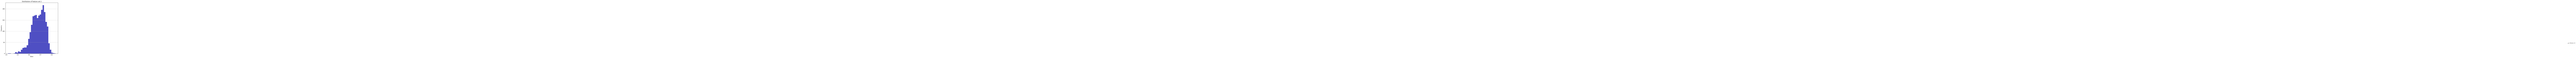

In [23]:
train_distances = distancesToCenter(train_points)
train_rescaled = distancesToCenter(train_points, rescale=True)

# An "interface" to matplotlib.axes.Axes.hist() method
plt.figure(figsize=(8, 8))
n_plot, bins, patches = plt.hist(x=train_rescaled[:, 1], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of feature set 2')
plt.text(23, 45, r'$\mu=15, b=3$')
plt.show()

In [41]:
def data_prepare(feature_set:np.array):
    X = feature_set[:,0: feature0.shape[1]-1]
    y = feature_set[:,-1]
    return(X, y)

In [43]:
X_f0, y_f0 = data_prepare(feature0)
X_f1, y_f1 = data_prepare(feature1)
print(X_f0.shape)
print(X_f1.shape)

(3000, 6006)
(3000, 3004)


## Step 4: Model train

In [88]:
# for leave-one-out: run function with K = n

def kfold_cv(model, X:np.array, y:np.array, K:int, lb:str):
    kf = KFold(n_splits=K, shuffle=True, random_state= RANDOM_STATE)
    
    tprs = []
    aucs = []
    acc = []
    mean_fpr = np.linspace(0, 1, 100)
    
    
    fig, ax = plt.subplots(figsize=(8, 8))
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        viz = plot_roc_curve(model, X_test, y_test,
                             #name='ROC fold {}'.format(i),
                             alpha=0.6, lw=1, ax=ax)
        acc.append(model.score(X_test, y_test))
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
    print('Mean accuracy = {:.3f}'.format(np.mean(acc)))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=lb + r' Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC curves "+lb)
    ax.legend(loc="best")
    return(fig, ax)
    #plt.show()

#### Model 0: baseline GBM on feature set 0

Fold  0 : accuracy = 0.808
Fold  1 : accuracy = 0.834
Fold  2 : accuracy = 0.821
Time for CV:  108.6533 s


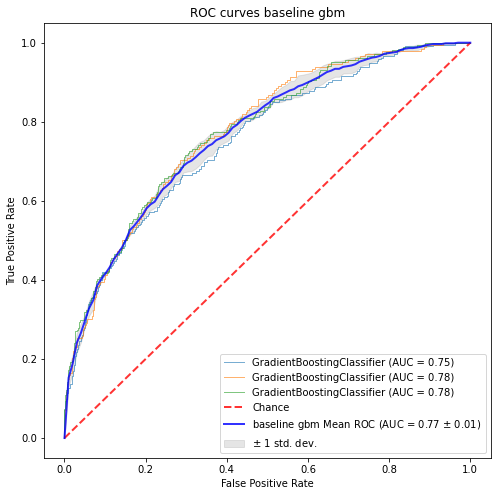

In [89]:
baseline_gbm = GradientBoostingClassifier(learning_rate=0.1, 
                                      n_estimators=100, n_iter_no_change=10, tol=0.01, # early stop
                                      random_state=0)

RUN_CV = True
if RUN_CV:
    #loo_cv(baseline_gbm, X_f0, y_f0, "baseline gbm")
    start = time.time()
    kfold_cv(baseline_gbm, X_f0, y_f0, K = 3, lb="baseline gbm")
    print("Time for CV: ", round(time.time()-start,4), "s")


In [94]:
RUN_CV = False
if RUN_CV == False:
    f0_train = np.array(feature0.loc[X_train, feature0.columns != 'label'])
    f0_test = np.array(feature0.loc[X_test, feature0.columns != 'label'])
    
    start = time.time()
    baseline_gbm.fit(f0_train,y_train)
    print("Time fit: ", round(time.time()-start,4), "s")
    predictors=list(f0_train)
    #feature_imp = pd.Series(baseline_gbm.feature_importances_, predictors).sort_values(ascending=False).head(10)
    #feature_imp.plot(kind='bar', title='Importance of Features')
    #plt.ylabel('Feature Importance Score')
    print('Accuracy of the GBM on test set: {:.3f}'.format(baseline_gbm.score(f0_test, y_test)))
    start = time.time()
    y_pred = baseline_gbm.predict(f0_test)
    print("Time predict: ", round(time.time()-start,4), "s")
    print(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(np.array(y_test), np.array(y_pred), pos_label=1)
    sklearn.metrics.auc(fpr, tpr)

Time fit:  60.802 s
Accuracy of the GBM on test set: 0.805
Time predict:  0.029 s
              precision    recall  f1-score   support

           0       0.81      0.97      0.89       469
           1       0.68      0.21      0.32       131

    accuracy                           0.81       600
   macro avg       0.74      0.59      0.60       600
weighted avg       0.78      0.81      0.76       600



In [ ]:
# TN FP
# FN TP
#sklearn.metrics.confusion_matrix(y_test, y_pred)

#### Model 1: Logistic regression

#### Model : Simply CNN (on images)

##### Imbalanced data treatment

1) Resampling: Downsampling the majority and upsampling the minority
2) Put class weights in penalty
3) Data augmentation of the minority

In [ ]:
cnn_1 = tf.keras.Sequential([
    #layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    #layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.Rescaling(1./255.),
    #layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(16, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.Dropout(0.2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')#, 
                 #bias_initializer=tf.keras.initializers.Constant(initial_bias))
])

cnn_1.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=METRICS)


start = time.time()
history = cnn_1.fit(train_data, validation_data=val_data, 
                   steps_per_epoch=np.ceil(2.0*n_ones/BATCH_SIZE),
                   epochs=20)
                   #class_weight=class_weight)
print("Time fit: ", round(time.time()-start,4), "s")

cnn_1.summary()

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 0.6934 - tp: 240.5833 - fp: 217.7500 - tn: 19572.1667 - fn: 19519.5000 - accuracy: 0.5010 - precision: 0.4432 - recall: 0.0121 - auc: 0.5043  

In [ ]:
def plot_cnn_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    pred_e = [1-a for a in acc]
    val_pred_e = [1-a for a in val_acc]
    
    prec = history.history['precision']
    val_prec = history.history['val_precision']
    
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    #def plot_metrics(metrics_list):
    epochs_range = range(NUM_EPOCHS)
    
    plt.figure(figsize=(15, 15))
    
    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, pred_e, label='Training Prediction Errors')
    plt.plot(epochs_range, val_pred_e, label='Validation Prediction Errors')
    plt.xlabel('Epoch')
    plt.ylabel('Prediction Error')
    plt.legend(loc='best')
    plt.title('Training and Validation Prediction Errors')
    
    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, prec, label='Training Precision')
    plt.plot(epochs_range, val_prec, label='Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.title('Training and Validation Precision')
    
    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, recall, label='Training Recall')
    plt.plot(epochs_range, val_recall, label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.title('Training and Validation Recall')
    
    plt.subplot(2, 3, 6)
    plt.plot(epochs_range, auc, label='Training AUC')
    plt.plot(epochs_range, val_auc, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(loc='best')
    plt.title('Training and Validation AUC')
    
    plt.show()

#### Model : Pretrained CNN (on images)

In [ ]:
# pretrained model
def MobileNetV2_model(metrics=METRICS, output_bias=None, adam_lr=5e-3):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    MobileNetV2 = tf.keras.applications.MobileNetV2(include_top=False,
                                                   weights="imagenet",
                                                   input_shape=(IMG_SIZE, IMG_SIZE, 3))
    MobileNetV2.trainable = False 
    data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        #layers.experimental.preprocessing.RandomZoom(0.2)
    ])
    preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
    dropout = tf.keras.layers.Dropout(0.2)
    
    model = tf.keras.Sequential([
        data_augmentation,
        preprocess_input,
        MobileNetV2,
        global_average_layer,
        prediction_layer
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=adam_lr),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                  metrics=metrics)

    return model


In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)



In [61]:
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                   weights="imagenet",
                                                   input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False 
data_augmentation = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        #layers.experimental.preprocessing.RandomZoom(0.2)
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
dropout = tf.keras.layers.Dropout(0.2)
    
model = tf.keras.Sequential([
        data_augmentation,
        preprocess_input,
        base_model,
        global_average_layer,
        prediction_layer
])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2),
                  loss=tf.keras.losses.BinaryCrossentropy(),#from_logits=True), 
                  metrics=METRICS)
class_weight = classWeights(n_zeros,n_ones)
NUM_EPOCHS = 20
start = time.time()
history = model.fit(train_data, validation_data=val_data, 
                   #callbacks=[early_stopping],
                   epochs=NUM_EPOCHS,
                   class_weight = class_weight)
print("Time fit: ", round(time.time()-start,4), "s")

Epoch 1/20
24/24 [==============================] - 58s 2s/step - loss: 0.9558 - tp: 156.0800 - fp: 521.4400 - tn: 912.8000 - fn: 205.6800 - accuracy: 0.6170 - precision: 0.2505 - recall: 0.4129 - auc: 0.5792 - val_loss: 0.5870 - val_tp: 207.0000 - val_fp: 412.0000 - val_tn: 1498.0000 - val_fn: 283.0000 - val_accuracy: 0.7104 - val_precision: 0.3344 - val_recall: 0.4224 - val_auc: 0.6610
Epoch 2/20
24/24 [==============================] - 53s 2s/step - loss: 0.6824 - tp: 173.7200 - fp: 471.3600 - tn: 557.6800 - fn: 93.2400 - accuracy: 0.5519 - precision: 0.2649 - recall: 0.6400 - auc: 0.6308 - val_loss: 0.7737 - val_tp: 437.0000 - val_fp: 1207.0000 - val_tn: 703.0000 - val_fn: 53.0000 - val_accuracy: 0.4750 - val_precision: 0.2658 - val_recall: 0.8918 - val_auc: 0.7187
Epoch 3/20
24/24 [==============================] - 54s 2s/step - loss: 0.6469 - tp: 182.4800 - fp: 432.4400 - tn: 591.4000 - fn: 89.6800 - accuracy: 0.5896 - precision: 0.2985 - recall: 0.6925 - auc: 0.6888 - val_loss: 

In [53]:
# 1) Upsampling the minority
# Train data
one_ds = ds_generator(list(ones.index))
one_ds = one_ds.repeat()
zero_ds = ds_generator(list(zeros.index))
zero_ds = zero_ds.repeat()

# Resample:
resampled_ds = tf.data.experimental.sample_from_datasets([one_ds, zero_ds], weights=[0.5, 0.5])

resampled_train_ds = resampled_ds.shuffle(SHUFFLE_SIZE)
resampled_train_data = resampled_train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

#val_data = resampled_ds.cache().batch(BATCH_SIZE).prefetch(2)


# Test data
test_ds = ds_generator(X_test)
test_data = test_ds.cache().batch(BATCH_SIZE)

#initial_bias = np.log([n_ones/n_zeros])[0]

In [55]:
mobileNetV2_base = MobileNetV2_model()

NUM_EPOCHS = 20
start = time.time()
history = mobileNetV2_base.fit(train_data, validation_data=test_data, 
                          #callbacks=[early_stopping],
                          steps_per_epoch=np.ceil(2.0*n_ones/BATCH_SIZE),
                          epochs=NUM_EPOCHS)
print("Time fit: ", round(time.time()-start,4), "s")

Epoch 1/20
12/12 [==============================] - 27s 2s/step - loss: 0.9571 - tp: 330.5385 - fp: 343.5385 - tn: 1391.3846 - fn: 1326.8462 - accuracy: 0.5076 - precision: 0.4906 - recall: 0.1963 - auc: 0.4914 - val_loss: 0.5462 - val_tp: 9.0000 - val_fp: 47.0000 - val_tn: 441.0000 - val_fn: 103.0000 - val_accuracy: 0.7500 - val_precision: 0.1607 - val_recall: 0.0804 - val_auc: 0.5464
Epoch 2/20
12/12 [==============================] - 21s 2s/step - loss: 0.7654 - tp: 88.7692 - fp: 97.3846 - tn: 276.6154 - fn: 229.5385 - accuracy: 0.5262 - precision: 0.4699 - recall: 0.2200 - auc: 0.4992 - val_loss: 0.7864 - val_tp: 86.0000 - val_fp: 321.0000 - val_tn: 167.0000 - val_fn: 26.0000 - val_accuracy: 0.4217 - val_precision: 0.2113 - val_recall: 0.7679 - val_auc: 0.5643
Epoch 3/20
12/12 [==============================] - 21s 2s/step - loss: 0.7224 - tp: 202.6923 - fp: 190.4615 - tn: 161.7692 - fn: 137.3846 - accuracy: 0.5181 - precision: 0.5092 - recall: 0.6078 - auc: 0.5172 - val_loss: 0.68

In [59]:
# 2) Reweight
#weight_for_0 = (1 / n_zeros)*(n_zeros+n_ones)/2.0 
#weight_for_1 = (1 / n_ones)*(n_zeros+n_ones)/2.0
class_weight = classWeights(n_zeros_test,n_ones_test)

train_ds = ds_generator(X_train)
test_ds = ds_generator(X_test)
train_ds = train_ds.cache()
train_data = train_ds.shuffle(SHUFFLE_SIZE)
train_data = train_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_data = train_ds.cache().batch(BATCH_SIZE)
test_data = test_ds.cache().batch(BATCH_SIZE)

NUM_EPOCHS = 20
start = time.time()
history = mobileNetV2_base.fit(train_data, validation_data=val_data, 
                          #callbacks=[early_stopping],
                          epochs=NUM_EPOCHS,
                          class_weight = class_weight)
print("Time fit: ", round(time.time()-start,4), "s")

Epoch 1/20
24/24 [==============================] - 58s 2s/step - loss: 0.4149 - tp: 4.0000 - fp: 0.0000e+00 - tn: 1910.0000 - fn: 486.0000 - accuracy: 0.7975 - precision: 1.0000 - recall: 0.0082 - auc: 0.7840 - val_loss: 0.4778 - val_tp: 13.0000 - val_fp: 0.0000e+00 - val_tn: 1910.0000 - val_fn: 477.0000 - val_accuracy: 0.8012 - val_precision: 1.0000 - val_recall: 0.0265 - val_auc: 0.8046
Epoch 2/20
24/24 [==============================] - 57s 2s/step - loss: 0.4070 - tp: 5.0000 - fp: 0.0000e+00 - tn: 1910.0000 - fn: 485.0000 - accuracy: 0.7979 - precision: 1.0000 - recall: 0.0102 - auc: 0.8007 - val_loss: 0.4865 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 1910.0000 - val_fn: 482.0000 - val_accuracy: 0.7992 - val_precision: 1.0000 - val_recall: 0.0163 - val_auc: 0.8063
Epoch 3/20
24/24 [==============================] - 57s 2s/step - loss: 0.4131 - tp: 5.0000 - fp: 0.0000e+00 - tn: 1910.0000 - fn: 485.0000 - accuracy: 0.7979 - precision: 1.0000 - recall: 0.0102 - auc: 0.7877 - val

KeyboardInterrupt: 

In [ ]:
# Set initial biases for imbalenced dataset
initial_bias = np.log([n_ones/n_zeros])
#mobileNetV2 = MobileNetV2_model(output_bias = initial_bias)




In [43]:
mobileNetV2_base = MobileNetV2_model()
NUM_EPOCHS = 20
X_train, X_test, y_train, y_test = train_test_split(range(3000), labels['label'], test_size=0.2, random_state = RANDOM_STATE)
# Train data
ones = y_train[labels['label']==1]
zeros = y_train[labels['label']==0]




train_ds = ds_generator(X_train)
train_ds = train_ds.cache()
train_data = train_ds.shuffle(SHUFFLE_SIZE)
train_data = train_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
print(train_ds)
print(train_data)
# Test data
test_ds = ds_generator(X_test)
test_data = test_ds.cache().batch(BATCH_SIZE)

#for img in train_ds.take(3):
#print(train_ds)
tm_cnn_fit = []

start = time.time()
history = mobileNetV2_base.fit(train_data, validation_data=test_data, 
                          callbacks=[early_stopping],
                          epochs=NUM_EPOCHS,
                          class_weight = class_weight)#, batch_size=20)
tm_cnn_fit.append(time.time() - start)

<CacheDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>
Epoch 1/20
24/24 [==============================] - 31s 1s/step - loss: 0.6161 - tp: 187.6400 - fp: 742.8400 - tn: 781.6000 - fn: 183.9200 - accuracy: 0.4702 - precision: 0.2011 - recall: 0.5658 - auc: 0.5203 - val_loss: 0.6562 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 473.0000 - val_fn: 127.0000 - val_accuracy: 0.7883 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4896
Epoch 2/20
24/24 [==============================] - 23s 965ms/step - loss: 0.3453 - tp: 2.8000 - fp: 4.5200 - tn: 1040.0400 - fn: 248.6400 - accuracy: 0.8022 - precision: 0.2922 - recall: 0.0078 - auc: 0.5103 - val_loss: 0.5532 - val_tp: 0.0000e+00 - val_fp: 4.0000 - val_tn: 469.0000 - val_fn: 127.0000 - val_accuracy: 0.7817 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4941
Epoch 3/20
24/24 [====================

In [ ]:
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, NUM_EPOCHS)

In [ ]:
# List all weight tensors 
# model.get_weights()
# plot metrics


# make predictions

test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)





#### 5-fold cross validated CNN

In [ ]:
import time
from sklearn.model_selection import LeaveOneOut, KFold
kf = KFold(n_splits = 5, random_state = 0, shuffle = True) 

VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_AUC = []

TIME_FIT = []

fold_var = 1

def get_model_name(k):
    return 'model_'+str(k)+'.h5'
#loo = LeaveOneOut()
#loo.get_n_splits(X)

y = labels['label']
for train_index, test_index in kf.split(np.zeros(3000),y):

    train_ds = ds_generator(train_index)
    val_ds = ds_generator(test_index) 
    
    for img, label in train_ds.take(1):
          print(img.shape, label.shape)
    for img, label in val_ds.take(1):
          print(img.shape, label.shape)
    
    train_data = train_ds.cache()
    train_data = train_ds.shuffle(SHUFFLE_SIZE)
    train_data = train_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    test_data = val_ds.cache().batch(BATCH_SIZE)
    
    for img, label in train_data.take(1):
          print(img.shape, label.shape)
    for img, label in test_data.take(1):
          print(img.shape, label.shape)
    
    # CREATE NEW MODEL
    initial_bias = np.log([n_ones/n_zeros])
    mobileNetV2 = MobileNetV2_model(output_bias = initial_bias)
    
    # CREATE CALLBACKS
    checkpoint_path = os.path.join(output_dir, get_model_name(fold_var))
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                            monitor='val_auc', verbose=1, 
                            save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    start = time.time()
    history = mobileNetV2.fit(train_data, validation_data=test_data, epochs=20)
    TIME_FIT.append(time.time() - start)
    #PLOT HISTORY
    #		:
    #		:
    
    # LOAD BEST MODEL to evaluate the performance of the model
    mobileNetV2.load_weights(output_dir+"model_"+str(fold_var)+".h5")
    
    results = mobileNetV2.evaluate(val_data)
    results = dict(zip(mobileNetV2.metrics_names,results))
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    VALIDATION_PRECISION.append(results['precision'])
    VALIDATION_RECALL.append(results['recall'])
    VALIDATION_AUC.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

# r environment

In [ ]:
!pip install rpy2

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%R 